In [1]:
import numpy as np
import xarray as xr
from scipy import stats  # for ttest
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [137]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [141]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [240]:
import matplotlib as mpl

In [192]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = np.array([[255,255,255],
                  [244,255,244],
                  [217,255,217], 
                  [163,255,163], 
                  [106,255,106],
                  [43,255,106], 
                  [0,224,0], 
                  [0,134,0],
                  [255,255,0],
                  [255,127,0]] ) / 255.
newcmp = ListedColormap(colors)


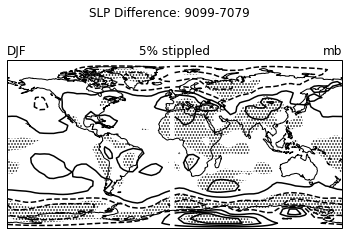

In [127]:
ds = xr.open_dataset("/Users/brianpm/Documents/www.ncl.ucar.edu/Applications/Data/cdf/slpNCEP.nc")
date = ds['date'].astype(int) # for some reason it will otherwise be float
slp  = ds['SLP']
# compute SEASONAL means
# slp_ts = slp(lat|:,lon|:,time|:)    # (lat,lon,time)
# slp_ts = runave (slp_ts, 3, 0)      # (lat,lon,time) 3-mo run ave
slp_ts = slp.rolling(time=3, center=True).mean()

slpAve7079 = slp_ts.sel(time=slice('1970-01-01', '1979-12-31')).groupby('time.month').mean(dim='time')
slpStd7079 = slp_ts.sel(time=slice('1970-01-01', '1979-12-31')).groupby('time.month').std(dim='time')
slpAve9099 = slp_ts.sel(time=slice('1990-01-01', '1999-12-31')).groupby('time.month').mean(dim='time')
slpStd9099 = slp_ts.sel(time=slice('1990-01-01', '1999-12-31')).groupby('time.month').std(dim='time')
# these will have a dimension 'month' instead of 'time'

tstat, prob = stats.ttest_ind_from_stats(slpAve9099, slpStd9099, 10,
  slpAve7079, slpStd7079, 10, equal_var=False)

# copy_VarCoords (slpAve9099, prob)
prob = xr.DataArray(prob, dims=slpAve9099.dims, coords=slpAve9099.coords)
prob.attrs['long_name'] = "Probability: difference between means"

difAve = slpAve9099 - slpAve7079 
# copy_VarCoords (slpAve9099, difAve)
difAve.attrs['long_name'] = "9099-7079" 
difAve.attrs['units']     = "mb"
  
nmo = 0                                # for demo, only plot Dec-Feb


In [163]:
# make the data cyclic

wrap_data, wrap_lon = add_cyclic_point(difAve, coord=difAve['lon'], axis=-1)
lons, lats = np.meshgrid(wrap_lon, difAve['lat'])
wrap_p = add_cyclic_point(prob)



In [162]:
lons.shape

(37, 73)

In [175]:
def set_contourthickness(contour, value, thickness=2):
    """Procedure to make contour line at value have given thickness."""
    contour.collections[np.argwhere(contour.levels == value).item()].set_linewidth(thickness) 

In [182]:
def set_NegativeContourColor(contour, color):
    # see: https://stackoverflow.com/questions/14264006/highlight-single-contour-line
    negcontours = np.where(contour.levels < 0)[0]
    [contour.collections[i].set_color(color) for i in negcontours]

Text(20, -130, 'CONTOUR FROM -6.0 to 6.0 by 2.0')

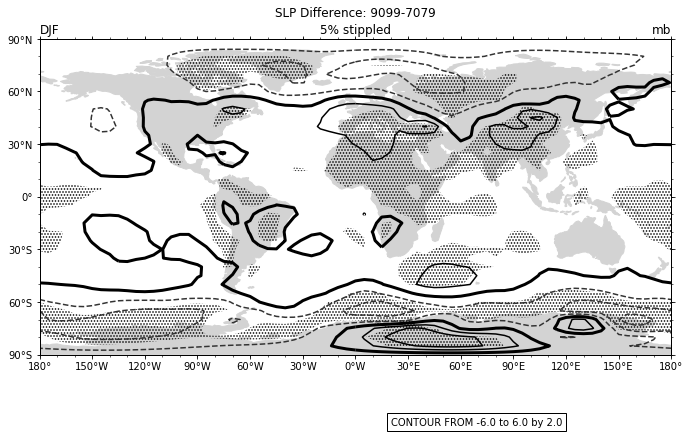

In [187]:
wks, ax = plt.subplots(figsize=(12,6), subplot_kw={"projection": ccrs.PlateCarree()}, constrained_layout=True)
cnLevels = np.arange(-6, 6+2, 2)
tiMainString = "SLP Difference: 9099-7079"
CenterString = "5% stippled"
LeftString = "DJF"
# lons, lats = np.meshgrid(difAve['lon'], difAve['lat'])
CS = ax.contour(lons, lats, wrap_data[nmo,:,:], transform=ccrs.PlateCarree(),
                levels=cnLevels, colors='k')  
# print(CS.levels)
# print(f"The index of the zero contour is {np.argwhere(CS.levels == 0).item()}")
# CS.collections[np.argwhere(CS.levels == 0).item()].set_linewidth(5) 
set_contourthickness(CS, 0, 3)
set_NegativeContourColor(CS, (.20, .20, .20))

wks.suptitle(tiMainString)
ax.set_title(CenterString)
ax.set_title(LeftString, loc='left')
ax.set_title(difAve.attrs['units'], loc='right')
# ax.coastlines()
ax.add_feature(cartopy.feature.LAND, color='lightgray')
# ax.add_feature(cartopy.feature.OCEAN)


ax.contourf(lons, lats, wrap_p[nmo, :, :], levels=[0.0, 0.07, prob.max().values.item()], 
  hatches=['....', ''], colors='none')

ax.set_xticks(np.arange(-180, 180+30, 30), crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax.xaxis.set_minor_locator(plt.MultipleLocator(10))
ax.yaxis.set_minor_locator(plt.MultipleLocator(10))


lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.tick_params(top=True, right=True, which='both', direction='out')
# Text to make a contour label:
ax.text( 20, -130, f"CONTOUR FROM {min(CS.levels)} to {max(CS.levels)} by {CS.levels[1]-CS.levels[0]}", bbox=dict(facecolor='none', edgecolor='black'))
# ax.tick_params(bottom=True, top=True, right=True, axis ='both', which ='major', direction='out', length = 10, labelbottom=True) 

In [22]:
cartopy.feature

<module 'cartopy.feature' from '/Users/brianpm/anaconda3/lib/python3.7/site-packages/cartopy/feature/__init__.py'>

In [23]:
!ls /Users/brianpm/anaconda3/lib/python3.7/site-packages/cartopy/feature

__init__.py   __pycache__   nightshade.py


In [28]:
cartopy.feature.LAND

In [31]:
import xarray as xr

In [39]:
import numpy as np

In [58]:
ds = xr.open_dataset("/Users/brianpm/Documents/www.ncl.ucar.edu/Applications/Data/cdf/slpNCEP.nc")
date = ds['date'].astype(int) # for some reason it will otherwise be float
slp  = ds['SLP']
# compute SEASONAL means
# slp_ts = slp(lat|:,lon|:,time|:)    # (lat,lon,time)
# slp_ts = runave (slp_ts, 3, 0)      # (lat,lon,time) 3-mo run ave
slp_ts = slp.rolling(time=3, center=True).mean()


In [90]:
slpAve7079 = slp_ts.sel(time=slice('1970-01-01', '1979-12-31')).mean(dim='time')
slpStd7079 = slp_ts.sel(time=slice('1970-01-01', '1979-12-31')).std(dim='time')
slpAve9099 = slp_ts.sel(time=slice('1990-01-01', '1999-12-31')).mean(dim='time')
slpStd9099 = slp_ts.sel(time=slice('1990-01-01', '1999-12-31')).std(dim='time')

In [98]:
tstat, prob = stats.ttest_ind_from_stats(slpAve9099, slpStd9099, 10,
  slpAve7079, slpStd7079, 10, equal_var=False)


In [99]:
prob = xr.DataArray(prob, dims=slpAve9099.dims, coords=slpAve9099.coords)
prob

<xarray.DataArray (lat: 37, lon: 72)>
array([[0.895644, 0.895644, 0.895644, ..., 0.895644, 0.895644, 0.895644],
       [0.924765, 0.885134, 0.847736, ..., 0.944742, 0.990203, 0.966404],
       [0.927703, 0.877218, 0.837857, ..., 0.796413, 0.917295, 0.994039],
       ...,
       [0.701693, 0.661256, 0.627123, ..., 0.798814, 0.775877, 0.742329],
       [0.597086, 0.599703, 0.603363, ..., 0.588342, 0.591413, 0.594341],
       [0.491251, 0.491251, 0.491251, ..., 0.491251, 0.491251, 0.491251]])
Coordinates:
  * lat      (lat) float32 -90.0 -85.0 -80.0 -75.0 -70.0 ... 75.0 80.0 85.0 90.0
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0

In [102]:
difAve = slpAve9099 - slpAve7079 
difAve

<xarray.DataArray (lat: 37, lon: 72)>
array([[-0.831604, -0.831604, -0.831604, ..., -0.831604, -0.831604, -0.831604],
       [ 0.585144,  0.946411,  1.317993, ..., -0.345947, -0.066345,  0.24469 ],
       [ 0.581482,  1.117676,  1.623657, ..., -0.93988 , -0.473022,  0.041077],
       ...,
       [-0.762573, -0.888794, -0.99054 , ..., -0.435364, -0.517029, -0.630737],
       [-0.972717, -0.975952, -0.975586, ..., -0.963074, -0.96582 , -0.969177],
       [-1.389343, -1.389343, -1.389343, ..., -1.389343, -1.389343, -1.389343]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -85.0 -80.0 -75.0 -70.0 ... 75.0 80.0 85.0 90.0
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0

In [105]:
np.arange(-6, 6+2, 2)

array([-6, -4, -2,  0,  2,  4,  6])

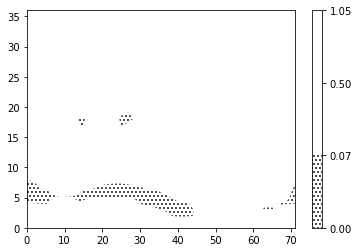

In [125]:
plt.contourf(prob, levels=[0.0, 0.07, .5, 1.05], hatches=['...', '', ''], colors='none')
plt.colorbar()

In [193]:
np.linspace(1,12,12)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [203]:
ds = xr.open_dataset("/Users/brianpm/Documents/www.ncl.ucar.edu/Applications/Data/cdf/xieArkin-T42.nc",
                    decode_times=False)
yymm = ds['time'].astype(int)
P = ds['prc']
lat = ds['lat']

Pclm  = P.groupby('time.month').mean(dim='time')     
# time need not be multiple of 12
Pzone = Pclm.mean(dim='lon')  # lat x month

#
# generate colormap using rgb triplets
#
colors = np.array([255,255,255],
                  [244,255,244],
                  [217,255,217], 
                  [163,255,163], 
                  [106,255,106],
                  [43,255,106], 
                  [0,224,0], 
                  [0,134,0],
                  [255,255,0],
                  [255,127,0] ) / 255.
newcmp = ListedColormap(colors)


wks, ax = plt.subplots()
cnLevels = [0.5,1.0,2.0,3.0,4.0,5.0,6.5,7.5]
mlat, mmonth = np.meshgrid(lat, np.linspace(1,12,12))
ax.contourf(mlat, mmonth, Pzone, cmap=newcmp, levels=cnLevels)  
ax.set_xticks = np.linspace(1,12,1)
ax.set_xticklabels(["J","F","M","A","M","J",
                    "J","A","S","O","N","D"])  
wks.suptitle("Zonally Averaged Annual Cycle")


AttributeError: 'IndexVariable' object has no attribute 'month'

In [206]:
ds = xr.open_dataset(
    "/Users/brianpm/Documents/www.ncl.ucar.edu/Applications/Data/cdf/xieArkin-T42.nc",
                    decode_times=False)


In [221]:
from datetime import datetime
import pandas as pd

In [220]:
# could use this to make an array of datetimes
# but Pandas is a bit easier
datetime.strptime('1979-01-15', '%Y-%m-%d')

datetime.datetime(1979, 1, 15, 0, 0)

In [222]:
otime = ds['time'].astype(int)
times = []
for t in otime:
    str_time = str(t.item())
    yy = str_time[0:2]
    mm = str_time[2:]
    yyint = int(yy)
    if (1900 + yyint) <= 2000:
        yyyy = 1900 + yyint
    else:
        yyyy = 2000 + yyint
    date = f'{yyyy}-{mm}-15'
#     print(f"YEAR: {yy} MONTH: {mm} ==> DATE: {date}")
    times.append(date)
time = pd.to_datetime(times)
time

YEAR: 79 MONTH: 01 ==> DATE: 1979-01-15
YEAR: 79 MONTH: 02 ==> DATE: 1979-02-15
YEAR: 79 MONTH: 03 ==> DATE: 1979-03-15
YEAR: 79 MONTH: 04 ==> DATE: 1979-04-15
YEAR: 79 MONTH: 05 ==> DATE: 1979-05-15
YEAR: 79 MONTH: 06 ==> DATE: 1979-06-15
YEAR: 79 MONTH: 07 ==> DATE: 1979-07-15
YEAR: 79 MONTH: 08 ==> DATE: 1979-08-15
YEAR: 79 MONTH: 09 ==> DATE: 1979-09-15
YEAR: 79 MONTH: 10 ==> DATE: 1979-10-15
YEAR: 79 MONTH: 11 ==> DATE: 1979-11-15
YEAR: 79 MONTH: 12 ==> DATE: 1979-12-15
YEAR: 80 MONTH: 01 ==> DATE: 1980-01-15
YEAR: 80 MONTH: 02 ==> DATE: 1980-02-15
YEAR: 80 MONTH: 03 ==> DATE: 1980-03-15
YEAR: 80 MONTH: 04 ==> DATE: 1980-04-15
YEAR: 80 MONTH: 05 ==> DATE: 1980-05-15
YEAR: 80 MONTH: 06 ==> DATE: 1980-06-15
YEAR: 80 MONTH: 07 ==> DATE: 1980-07-15
YEAR: 80 MONTH: 08 ==> DATE: 1980-08-15
YEAR: 80 MONTH: 09 ==> DATE: 1980-09-15
YEAR: 80 MONTH: 10 ==> DATE: 1980-10-15
YEAR: 80 MONTH: 11 ==> DATE: 1980-11-15
YEAR: 80 MONTH: 12 ==> DATE: 1980-12-15
YEAR: 81 MONTH: 01 ==> DATE: 1981-01-15


DatetimeIndex(['1979-01-15', '1979-02-15', '1979-03-15', '1979-04-15',
               '1979-05-15', '1979-06-15', '1979-07-15', '1979-08-15',
               '1979-09-15', '1979-10-15',
               ...
               '1996-03-15', '1996-04-15', '1996-05-15', '1996-06-15',
               '1996-07-15', '1996-08-15', '1996-09-15', '1996-10-15',
               '1996-11-15', '1996-12-15'],
              dtype='datetime64[ns]', length=216, freq=None)

In [225]:
ds['time'] = time
ds

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 216)
Coordinates:
  * lat      (lat) float32 -87.8638 -85.09653 -82.31291 ... 85.09653 87.8638
  * lon      (lon) float32 0.0 2.8125 5.625 8.4375 ... 351.5625 354.375 357.1875
  * time     (time) datetime64[ns] 1979-01-15 1979-02-15 ... 1996-12-15
Data variables:
    gwgt     (lat) float32 ...
    prc      (time, lat, lon) float32 ...
Attributes:
    title:        CPC Merged Monthly Precipitation Estimates
    source:       Pingping Xie and Phil Arkin (CPC); xping@sgi17.wwb.noaa.gov
    history:      \nFile read in the original format received \nCPC source na...
    references:   \nXie and Arkin, 1996:\nAnalyses of Global Monthly Precipit...
    Conventions:  none

In [356]:
P = ds['prc']
lat = ds['lat']

Pclm  = P.groupby('time.month').mean(dim='time', keep_attrs=True)     
# time need not be multiple of 12
Pzone = Pclm.mean(dim='lon', keep_attrs=True)  # lat x month

#
# generate colormap using rgb triplets
#
colors = np.array([[255,255,255],
                  [244,255,244],
                  [217,255,217], 
                  [163,255,163], 
                  [106,255,106],
                  [43,255,106], 
                  [0,224,0], 
                  [0,134,0],
                  [255,255,0],
                  [255,127,0]] ) / 255.
newcmp = ListedColormap(colors)


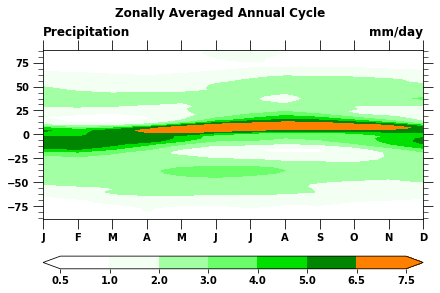

In [389]:
plt.rcParams["font.weight"] = "bold"

wks2,ax2 = plt.subplots(constrained_layout=True)
ax2.tick_params(bottom=True, top=True, right=True, axis ='both', which ='major', 
                direction='out')
ax2.tick_params(which='major', length=10)
ax2.tick_params(which='minor', length=5, left=True, right=True, bottom=False)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

# ax2.tick_params(which='minor', length=4, color='r')
ax2.set_xticks(np.arange(1,13,1))
cnLevels = [0.5,1.0,2.0,3.0,4.0,5.0,6.5,7.5]
mlat, mmonth = np.meshgrid(lat, np.linspace(1,12,12))
# norm = mpl.colors.Normalize(vmin=0.5, vmax=7.5)
norm = mpl.colors.BoundaryNorm(cnLevels, newcmp.N)

img = ax2.contourf(mmonth, mlat, Pzone, extend='both', levels=cnLevels, norm=norm,cmap=newcmp)  

ax2.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"])

# BONUS: plot a point at the maximum value
# mxloc = np.nonzero(Pzone.values == Pzone.max().values.item())
# mxpt = Pzone[xy[0][0], xy[1][0]]
# ax2.plot(mxpt.month, mxpt.lat, 'xk')
# ax2.text(mxpt.month, mxpt.lat, f"max: {Pzone.max().values.item():.1f}")

if hasattr(Pzone, 'units'):
    ax2.set_title(Pzone.units, loc='right', y=1.05, fontweight='bold')
else:
    print("No units? Did you remember to use keep_attrs when averaging?")
    print(Pzone)
if hasattr(Pzone, 'long_name'):
    ax2.set_title(Pzone.long_name, loc='left', y=1.05, fontweight='bold')
else:
    print("No long_name attribute found.")    


wks2.suptitle("Zonally Averaged Annual Cycle", fontweight='bold')
wks2.colorbar(img, orientation='horizontal', extend='both', cmap=newcmp, ticks=cnLevels, boundaries=cnLevels) 

In [348]:
xy = np.nonzero(Pzone.values == Pzone.max().values.item())
print(xy)
print(xy[0])
print(Pzone.shape)
print(Pzone[xy[0][0], xy[1][0]])

(array([5]), array([34]))
[5]
(12, 64)
<xarray.DataArray 'prc' ()>
array(9.132892, dtype=float32)
Coordinates:
    lat      float32 6.9765334
    month    int64 6


In [334]:
Pzone.max().values

array(9.13289165)

In [343]:
Pzone[5,34]

<xarray.DataArray 'prc' ()>
array(9.132892, dtype=float32)
Coordinates:
    lat      float32 6.9765334
    month    int64 6

In [347]:
Pzone[xy[0][0], xy[1][0]]

<xarray.DataArray 'prc' ()>
array(9.132892, dtype=float32)
Coordinates:
    lat      float32 6.9765334
    month    int64 6

In [399]:
a,b = np.where((6.5 < Pzone) & (Pzone <= 7.5))

In [400]:
a

array([3, 5, 7, 9])

In [401]:
b

array([33, 35, 36, 35])

In [402]:
Pzone[3,33]

<xarray.DataArray 'prc' ()>
array(7.028192, dtype=float32)
Coordinates:
    lat      float32 4.1859207
    month    int64 4
Attributes:
    short_name:  PRC
    long_name:   Precipitation
    units:       mm/day

In [404]:
ds = xr.open_dataset("/Users/brianpm/Dropbox/DataTemporary/B1850_c201_CTL.cam.h0.TS.ncrcat.nc")

ts = ds['TS']                            # read in data
if 'gw' in ds:
    gw = ds['gw']                            # get gaussian weights for ave
else:
    gw = np.cos(np.radians(ds['lat']))


# normalized weights:
ywnorm = gw / gw.sum()
a = (ts * ywnorm).sum(dim='lat')

In [408]:
a.mean(dim=('lon'))

<xarray.DataArray (time: 288)>
array([286.140608, 286.093106, 286.925754, ..., 288.502423, 287.626023,
       286.771871])
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 0025-01-01 00:00:00

In [25]:
latS =    0
latN =   70
lonW = -120
lonE =    0

dlat =  2.0                    
dlon =  2.0

nlat = ((latN-latS) // dlat) + 1  # use integer division
mlon = ((lonE-lonW) // dlon) + 1

print(f"The type of latS is {type(latS)} and the type of nlat is {type(nlat)}")

lat  = np.linspace(latS, latN, nlat)
lon  = np.linspace(lonW, lonE, mlon)
lat = xr.DataArray(lat, dims="lat", coords={"lat": lat}, attrs={"units":"degrees_north"})
lon = xr.DataArray(lon, dims="lon", coords={"lon": lon}, attrs={"units":"degrees_east"})
print(lat)

The type of latS is <class 'int'> and the type of nlat is <class 'float'>
<xarray.DataArray (lat: 36)>
array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24., 26.,
       28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50., 52., 54.,
       56., 58., 60., 62., 64., 66., 68., 70.])
Coordinates:
  * lat      (lat) float64 0.0 2.0 4.0 6.0 8.0 10.0 ... 62.0 64.0 66.0 68.0 70.0
Attributes:
    units:    degrees_north


/Users/brianpm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/brianpm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


In [26]:
clat = np.random.normal(size=10000, loc=23, scale=10)    
clon = np.random.normal(loc=-90, scale=10, size=10000)
cval = np.random.normal(loc=75, scale=20, size=10000)

clon = np.where(clon < lonW, np.nan, clon)  # deal with bogus outliers 
clon = np.where(clon > lonE, np.nan, clon)
clat = np.where(clat < latS, np.nan, clat)
clat = np.where(clat > latN, np.nan, clat)


/Users/brianpm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/brianpm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [47]:
valavg, latedge, lonedge, binum = stats.binned_statistic_2d(clat, clon, cval, 
                        statistic='mean', bins=[lat, lon], 
                        expand_binnumbers=False)


In [48]:
valavg.shape

(35, 60)

In [49]:
(latN-latS)/2

35.0

In [50]:
binum.shape

(10000,)

In [54]:
binum_2d = np.unravel_index(binum, [len(lat)+2, len(lon)+2])

In [57]:
binum_2d

(array([13,  6, 11, ..., 14, 15, 11]), array([ 0,  7,  2, ..., 60,  0,  8]))

In [45]:
binum[:,1]

array([ 6, 13])

In [60]:
density_vals = np.unravel_index(np.bincount(binum), [len(lat)+2, len(lon)+2])

In [92]:
density_vals[1].shape

(2260,)

In [71]:
np.bincount(binum).max()

74

In [75]:
lats, lons = np.meshgrid(lat, lon)

In [82]:
binum.shape

(10000,)

In [83]:
valavg.shape

(35, 60)

In [91]:
(35+2)*(60+2)

2294

In [95]:
(len(lat)+1) * (len(lon)+1)

2294

In [107]:
2260/66

34.24242424242424